In [51]:
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import pickle

In [8]:
from sklearn.feature_selection import RFE

In [98]:
# read in data
total_df = pd.read_csv('total_df.csv')

In [99]:
total_df

,priceSalesRatio,bookValuePerShare,grossProfitGrowth,totalOtherIncomeExpensesNet,inventoryGrowth,averagePayables,cashAtEndOfPeriod,pfcfRatio,otherExpenses,Headcount Growth Rate,...,cashRatio,daysOfPayablesOutstanding,grossProfitRatio,Layoffs,Market Cap_Large Cap,Market Cap_Mega Cap,Market Cap_Micro Cap,Market Cap_Mid Cap,Market Cap_Nano Cap,Market Cap_Small Cap
0,2.753718,56.650163,0.233252,-1.010667e+08,0.309747,1.786328e+08,8.278667e+08,16.900002,2.032000e+08,87.931034,...,1.559581,49.455494,0.451500,0,0,0,0,1,0,0
1,6.747642,30.446408,4.754562,-4.962300e+07,0.000000,2.593200e+07,1.768066e+10,4.969610,6.303080e+08,198.638911,...,0.623825,11.466811,0.838264,1,1,0,0,0,0,0
2,0.385808,124.678729,-0.020037,-8.950000e+08,0.185543,3.520417e+10,1.622600e+10,20.152112,3.973333e+08,8.333333,...,0.259653,126.183396,0.171405,0,0,0,0,1,0,0
3,12.489858,0.181337,0.445312,1.665267e+07,1.049301,1.485033e+07,6.543333e+06,25844.683072,8.618333e+06,19.799139,...,0.247727,40.857947,0.389465,0,0,0,0,1,0,0
4,0.340962,262.006000,0.356486,1.054285e+08,0.436971,6.316611e+09,7.815326e+09,-2.256531,-5.823669e+08,27.375723,...,0.194829,60.706969,0.162191,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,1.879526,2738.079615,0.000850,7.560000e+08,0.055448,8.103570e+10,1.972573e+11,33.911015,9.723333e+08,3.620653,...,0.955211,68.549517,0.452561,0,1,0,0,0,0,0
637,10.975483,49.412363,0.154069,-1.543133e+07,0.000000,4.247590e+07,3.622170e+08,49.256035,4.262467e+07,30.057803,...,0.482336,21.817797,0.451724,0,1,0,0,0,0,0
638,15.001349,11.909725,0.398543,-2.597000e+06,0.000000,8.681500e+06,8.839900e+07,-166.383627,0.000000e+00,19.379015,...,0.504737,37.236139,0.593183,1,0,0,0,1,0,0
639,6.150032,15.977752,0.323007,1.519867e+07,0.000000,4.645300e+07,6.381583e+08,-57.226773,2.210000e+05,21.739130,...,3.721951,136.043062,0.664945,0,0,0,0,0,0,1


In [100]:
dummy_columns = ['Market Cap_Large Cap', 'Market Cap_Mega Cap', 'Market Cap_Micro Cap',
       'Market Cap_Mid Cap', 'Market Cap_Nano Cap', 'Market Cap_Small Cap']
drop_columns = ["Layoffs", "Ticker"] + dummy_columns
X_df = total_df.drop(columns=drop_columns)
y_df, tickers = total_df["Layoffs"], total_df["Ticker"]
X_dummy = total_df[dummy_columns]
scaler = StandardScaler()
total_arr_scaled = scaler.fit_transform(X_df)

In [101]:
column_names = X_df.columns.to_list() + dummy_columns

In [102]:
# concatenate scaled data with dummy variables
total_arr_scaled = np.concatenate((total_arr_scaled, X_dummy), axis=1)

## Feature Selection

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
# determing effect of feature selection on dimensionality reduction

class_weights = {0: 1, 1: 4}

X_train, X_test, y_train, y_test = train_test_split(total_arr_scaled, y_df, test_size=0.3, random_state=42, stratify=y_df)
# rf = RandomForestClassifier(n_estimators=100, max_depth=2, class_weight=class_weights, random_state=0)
# rf.fit(X_train, y_train)
# svc = SVC(kernel="rbf", C=1584.893192461114, gamma= 1.0)
# svc.fit(total_arr_scaled, y_df)
# list of features to select
n_features_to_select = [50]
# empty list to store accuracy scores
accuracy_scores = []
# number of PCA components
num_components_list = []
feature_dict = {}
# loop over number of features to select
for n in n_features_to_select:
    # random forest grid search
    # param_grid = {"n_estimators": [100, 200, 500], 'max_depth':[2, 5, 10]}
    rf = RandomForestClassifier(n_estimators=100, max_depth=2, class_weight=class_weights, random_state=0)
    # grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring="f1", verbose=1, n_jobs=-1)
    # grid.fit(X_train, y_train)
    # rf2 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight=class_weights)
    print(f"Training model with {n} features")
    # select n features
    rfe = RFE(rf, n_features_to_select=n)
    rfe.fit(X_train, y_train)
    # get selected features
    selected_features = [column for column, selected in zip(column_names, rfe.support_) if selected]
    feature_dict[n] = selected_features
    # reduce data to selected features
    X_rfe = rfe.transform(X_train)
    # train model
    rf.fit(X_rfe, y_train)
    # evaluate model
    X_test_rfe = rfe.transform(X_test)
    y_pred = rf.predict(X_test_rfe)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    print(f"Accuracy score, {n} features: {accuracy_score(y_test, y_pred)}")
    print(f"F1 score, {n} features: {f1_score(y_test, y_pred)}")
    # # dimensionality reduction
    # pca = PCA(n_components=0.95)
    # # index X train with selected features
    # X_train_red = X_train[:, rfe.support_]
    # pca = PCA(n_components=0.95)
    # # save selected features
    # selected_features = X_df.columns[rfe.support_].tolist()
    # # index X train with selected features
    # pca.fit(X_train_red)
    # X_train_pca = pca.transform(X_train_red)
    # num_components = X_train_pca.shape[1]
    # print(f"Number of components: {num_components}")
    # # num_components_list.append(num_components)
    # rf3 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight=class_weights)
    # rf3.fit(X_train_pca, y_train)
    # # evaluate model
    # X_test_pca = pca.transform(X_test[:, rfe.support_])
    # y_pred_pca = rf3.predict(X_test_pca)
    # print(f"F1 score, {num_components} components: {f1_score(y_test, y_pred)}")
    # kernel_pca = KernelPCA(n_components=num_components, kernel="rbf")
    # kernel_pca.fit(X_train_red)
    # X_train_kernel_pca = kernel_pca.transform(X_train_red)
    # rf4 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight=class_weights)
    # rf4.fit(X_train_kernel_pca, y_train)
    # # evaluate model
    # X_test_kernel_pca = kernel_pca.transform(X_test[:, rfe.support_])
    # y_pred_kernel_pca = rf4.predict(X_test_kernel_pca)
    # print(f"F1 score, {num_components} kernel PCA components: {f1_score(y_test, y_pred)}")
    # num_components_list.append(num_components)
# rfe = RFE(rf, n_features_to_select=100)
# rfe.fit(X_train, y_train) 

Training model with 50 features
Accuracy score, 50 features: 0.9015544041450777
F1 score, 50 features: 0.6984126984126984


In [105]:
# save model to disk
with open("rf.pkl", "wb") as f:
    pickle.dump(rf, f)

In [106]:
selected_columns = feature_dict[50]

In [107]:
sliced_arr = total_arr_scaled[:, rfe.support_]

In [108]:
total_arr_scaled.shape

(641, 199)

In [109]:
len(selected_columns)

50

In [110]:
output_df = total_df[selected_columns + ["Layoffs", "Ticker"]]
output_df[selected_columns] = sliced_arr

C:\Users\Sai Ramesh\AppData\Local\Temp\ipykernel_14908\4054492523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df[selected_columns] = sliced_arr


In [111]:
total_df

,priceSalesRatio,bookValuePerShare,grossProfitGrowth,totalOtherIncomeExpensesNet,inventoryGrowth,averagePayables,cashAtEndOfPeriod,pfcfRatio,otherExpenses,Headcount Growth Rate,...,cashRatio,daysOfPayablesOutstanding,grossProfitRatio,Layoffs,Market Cap_Large Cap,Market Cap_Mega Cap,Market Cap_Micro Cap,Market Cap_Mid Cap,Market Cap_Nano Cap,Market Cap_Small Cap
0,2.753718,56.650163,0.233252,-1.010667e+08,0.309747,1.786328e+08,8.278667e+08,16.900002,2.032000e+08,87.931034,...,1.559581,49.455494,0.451500,0,0,0,0,1,0,0
1,6.747642,30.446408,4.754562,-4.962300e+07,0.000000,2.593200e+07,1.768066e+10,4.969610,6.303080e+08,198.638911,...,0.623825,11.466811,0.838264,1,1,0,0,0,0,0
2,0.385808,124.678729,-0.020037,-8.950000e+08,0.185543,3.520417e+10,1.622600e+10,20.152112,3.973333e+08,8.333333,...,0.259653,126.183396,0.171405,0,0,0,0,1,0,0
3,12.489858,0.181337,0.445312,1.665267e+07,1.049301,1.485033e+07,6.543333e+06,25844.683072,8.618333e+06,19.799139,...,0.247727,40.857947,0.389465,0,0,0,0,1,0,0
4,0.340962,262.006000,0.356486,1.054285e+08,0.436971,6.316611e+09,7.815326e+09,-2.256531,-5.823669e+08,27.375723,...,0.194829,60.706969,0.162191,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,1.879526,2738.079615,0.000850,7.560000e+08,0.055448,8.103570e+10,1.972573e+11,33.911015,9.723333e+08,3.620653,...,0.955211,68.549517,0.452561,0,1,0,0,0,0,0
637,10.975483,49.412363,0.154069,-1.543133e+07,0.000000,4.247590e+07,3.622170e+08,49.256035,4.262467e+07,30.057803,...,0.482336,21.817797,0.451724,0,1,0,0,0,0,0
638,15.001349,11.909725,0.398543,-2.597000e+06,0.000000,8.681500e+06,8.839900e+07,-166.383627,0.000000e+00,19.379015,...,0.504737,37.236139,0.593183,1,0,0,0,1,0,0
639,6.150032,15.977752,0.323007,1.519867e+07,0.000000,4.645300e+07,6.381583e+08,-57.226773,2.210000e+05,21.739130,...,3.721951,136.043062,0.664945,0,0,0,0,0,0,1


In [112]:
output_df.to_csv("df_selected.csv", index=False)

In [113]:
# save selected columns
with open("selected_columns.pkl", "wb") as f:
    pickle.dump(selected_columns, f)

In [114]:
# get misclassified samples
misclassified_indices = np.where((y_test == 0) & (y_pred == 1))[0]
test_indices = y_test.index[misclassified_indices]
# len(misclassified_indices)
tickers.loc[test_indices]

577    BKNG
464    SHOP
524    NVDA
271     NOW
605    INTU
563      SQ
178    PANW
398     BOX
5      CTXS
375    ATVI
506    CRWD
301     ZEN
Name: Ticker, dtype: object

In [59]:
remaining_features = X_df.columns[rfe.support_]
remaining_indices = [X_df.columns.get_loc(col) for col in remaining_features]

Text(50.722222222222214, 0.5, 'True Label')

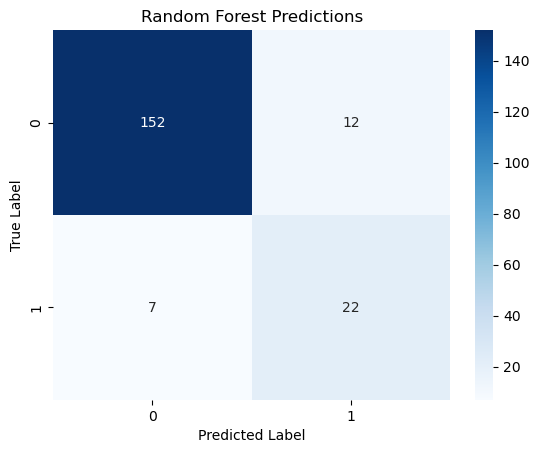

In [104]:
# y_pred = rfe.predict(X_test)

classification_report(y_test, y_pred)
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Random Forest Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [54]:
total_df.columns[:-1][rfe.support_]


AttributeError: 'RFE' object has no attribute 'support_'

In [24]:
y_df

0      0
1      0
2      0
3      1
4      0
      ..
719    1
720    1
721    0
722    0
723    1
Name: Layoffs, Length: 724, dtype: int64

In [25]:
np.mean(rf.predict(total_arr_scaled) == y_df.values)

0.8977900552486188

## Dimensionality Reduction

In [62]:
pca = PCA(n_components=0.95)

data_pca = pca.fit_transform(total_arr_scaled[:, remaining_indices])
kernel_pca = KernelPCA(n_components=pca.n_components_, kernel="rbf")
data_kernel_pca = kernel_pca.fit_transform(total_arr_scaled)

In [63]:
data_kernel_pca.shape

(724, 39)

In [47]:
X_df

,incomeBeforeTaxRatio,operatingCashFlowGrowth,operatingIncomeGrowth,evToSales,averagePayables,tangibleBookValuePerShare,epsdilutedGrowth,enterpriseValueOverEBITDA,netIncomeRatio,accountsPayables,pocfratio,intangiblesToTotalAssets,grossProfitRatio,ebitgrowth,researchAndDevelopmentExpenses,netCashProvidedByOperatingActivities,ebitPerRevenue,netIncomePerShare,sellingGeneralAndAdministrativeExpenses,inventoryGrowth,returnOnEquity,assetTurnover,fiveYDividendperShareGrowthPerShare,changeInWorkingCapital,investmentsInPropertyPlantAndEquipment,evToFreeCashFlow,returnOnTangibleAssets,netCurrentAssetValue,otherWorkingCapital,priceEarningsRatio,priceToBookRatio,cashConversionCycle,fiveYNetIncomeGrowthPerShare,shareholdersEquityPerShare,capexToOperatingCashFlow,interestDebtPerShare,netCashUsedProvidedByFinancingActivities,pfcfRatio,capexToRevenue,epsdiluted,rdexpenseGrowth,weightedAverageSharesGrowth,salesMaturitiesOfInvestments,operatingCashFlowSalesRatio,fiveYRevenueGrowthPerShare,cashPerShare,threeYNetIncomeGrowthPerShare,eps,tangibleAssetValue,receivablesGrowth,threeYDividendperShareGrowthPerShare,priceFairValue,netIncome,bookValuePerShare,peRatio,debtRatio,salesGeneralAndAdministrativeToRevenue,priceBookValueRatio,freeCashFlow,cashRatio,weightedAverageShsOutDil,grahamNetNet,cashFlowToDebtRatio,weightedAverageShsOut,freeCashFlowPerShare,incomeQuality,revenueGrowth,costAndExpenses,bookValueperShareGrowth,priceSalesRatio,grossProfitMargin,netCashUsedForInvestingActivites,threeYShareholdersEquityGrowthPerShare,enterpriseValue,tenYNetIncomeGrowthPerShare,sgaexpensesGrowth,sellingAndMarketingExpenses,ebitdaratio,netChangeInCash,netProfitMargin,receivablesTurnover,cik,freeCashFlowYield,cashAtBeginningOfPeriod,quickRatio,ptbRatio,acquisitionsNet,payablesTurnover,daysPayablesOutstanding,returnOnAssets,operatingExpenses,ebitda,threeYRevenueGrowthPerShare,capitalExpenditureCoverageRatio,freeCashFlowGrowth,calendarYear,otherExpenses,grossProfitGrowth,interestIncome,commonStockRepurchased,pretaxProfitMargin,incomeBeforeTax,costOfRevenue,priceCashFlowRatio,otherFinancingActivites,weightedAverageSharesDilutedGrowth,ebtPerEbit,grahamNumber,threeYOperatingCFGrowthPerShare,currentRatio,dividendsPaid,otherInvestingActivites,daysOfPayablesOutstanding,netIncomePerEBT,roic,tenYDividendperShareGrowthPerShare,freeCashFlowOperatingCashFlowRatio,cashFlowCoverageRatios,stockBasedCompensationToRevenue,deferredIncomeTax,otherNonCashItems,purchasesOfInvestments,fiveYShareholdersEquityGrowthPerShare,inventory,daysOfInventoryOutstanding,debtToEquity,enterpriseValueMultiple,debtEquityRatio,averageInventory,effectOfForexChangesOnCash,fiveYOperatingCFGrowthPerShare,dividendsperShareGrowth,shortTermCoverageRatios,priceToSalesRatio,capexPerShare,pbRatio,priceToFreeCashFlowsRatio,stockBasedCompensation,investedCapital,incomeTaxExpense,totalDebtToCapitalization,debtGrowth,daysOfSalesOutstanding,researchAndDdevelopementToRevenue,workingCapital,cashAtEndOfPeriod,capexToDepreciation,dividendPaidAndCapexCoverageRatio,priceEarningsToGrowthRatio,evToOperatingCashFlow,marketCap,operatingProfitMargin,priceToOperatingCashFlowsRatio,operatingCashFlow,operatingCashFlowPerShare,payoutRatio,totalOtherIncomeExpensesNet,commonStockIssued,interestCoverage,epsgrowth,accountsReceivables,capitalExpenditure,roe,debtToAssets,tenYRevenueGrowthPerShare,companyEquityMultiplier,netIncomeGrowth,operatingIncomeRatio,interestExpense,tenYOperatingCFGrowthPerShare,earningsYield,dividendYield,grossProfit,returnOnCapitalEmployed,longTermDebtToCapitalization,fixedAssetTurnover,daysOfInventoryOnHand,assetGrowth,revenue,daysSalesOutstanding,debtRepayment,tenYShareholdersEquityGrowthPerShare,generalAndAdministrativeExpenses,operatingIncome,effectiveTaxRate,dividendPayoutRatio,netDebtToEBITDA,depreciationAndAmortization,operatingCycle,revenuePerShare,inventoryTurnover,averageReceivables
0,-2857.363411,-1.934860,-0.734519,56910.365261,2.538413e+05,-0.003814,0.359604,-17.789295,-2936.927059,1.712567e+05,-35.04

## RBF SVC

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
# compare across random seeds
# seeds = [42, 43, 44, 45, 46, 47, 48, 49, 50]
seeds = [42]
# compare across different train/test splits
# train_sizes = [0.7, 0.8, 0.9]
train_sizes = [0.8]
X, y = data_kernel_pca, y_df.values
# X, y = total_arr_scaled, y_df.values
# define the hyperparameter grid
C_vals = np.logspace(-4, 4, 11)
gamma_vals = np.logspace(-4, 4, 11)
param_grid = {'C': C_vals, 'gamma': gamma_vals}
# svc = SVC(kernel="rbf", C=1584.893192461114, gamma= 1.0)
# svc.fit(total_arr_scaled, y_df)
# rfe = RFE(svc, n_features_to_select=100)
# rfe.fit(total_arr_scaled, y_df) 

for seed in seeds:
    for train_size in train_sizes:
        class_weights = {0: 1, 1: 4}
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=seed, stratify=y_df.values)
        svm = SVC(kernel='rbf', class_weight=class_weights, probability=True, random_state=seed)
        grid = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_params = grid.best_params_
        best_score = grid.best_score_

        print("Best Hyperparameters:", best_params)
        print("Best Score:", best_score)
        y_pred = grid.predict(X_test)
        y_train_pred = grid.predict(X_train)
        y_pred_proba = grid.predict_proba(X_test)
        print("Train size: {}, Seed: {}, Train accuracy: {}, Test accuracy: {}".format(train_size, seed, accuracy_score(y_train, y_train_pred),  accuracy_score(y_test, y_pred)))



Best Hyperparameters: {'C': 1.0, 'gamma': 1584.893192461114}
Best Score: 0.8203799654576857
Train size: 0.8, Seed: 42, Train accuracy: 1.0, Test accuracy: 0.8413793103448276


In [25]:
layoff_probas = y_pred_proba[:, 1]

In [52]:
f1_score(y_test, y_pred)

0.30303030303030304

Text(50.722222222222214, 0.5, 'True Label')

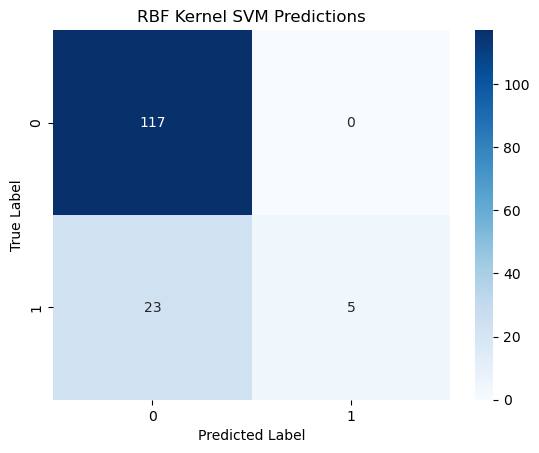

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("RBF Kernel SVM Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [41]:
_, X_df_test, _, y_df_test = train_test_split(X_df, y_df, train_size=train_size, random_state=seed)

In [53]:
misclassified_companies = X_df_test.iloc[np.where(y_pred != y_test) and np.where(y_pred == 1)]

(array([  9,  11,  14,  15,  18,  19,  21,  22,  25,  26,  27,  31,  37,
         38,  39,  43,  46,  47,  50,  52,  56,  58,  66,  73,  75,  77,
         81,  83,  84,  86,  87,  90,  91,  95, 105, 106, 107, 109],
       dtype=int64),)

Int64Index([412, 373, 188,  10,   6, 101, 234, 482, 442, 438, 362, 512, 369,
             84,   2, 525, 324,  90, 380, 541,  73, 375, 272,  82, 172, 542,
            145, 167,  75, 489,  68, 218, 237, 176, 248,  89, 547, 177],
           dtype='int64')

In [57]:
total_df.iloc[misclassified_companies.index]

,operatingCashFlowGrowth,otherInvestingActivites,grossProfitGrowth,priceFairValue,capexPerShare,costOfRevenue,daysPayablesOutstanding,priceSalesRatio,netIncomePerShare,sellingAndMarketingExpenses,assetGrowth,commonStockIssued,averageInventory,freeCashFlowGrowth,netCashUsedForInvestingActivites,debtToAssets,enterpriseValueOverEBITDA,priceToSalesRatio,assetTurnover,netCashUsedProvidedByFinancingActivities,inventoryGrowth,payablesTurnover,sgaexpensesGrowth,threeYRevenueGrowthPerShare,ebitdaratio,accountsReceivables,salesMaturitiesOfInvestments,marketCap,priceEarningsToGrowthRatio,incomeTaxExpense,operatingCashFlowSalesRatio,costAndExpenses,ebitPerRevenue,operatingIncome,epsgrowth,debtRepayment,incomeBeforeTax,priceEarningsRatio,interestDebtPerShare,dividendsperShareGrowth,returnOnTangibleAssets,cashFlowCoverageRatios,debtEquityRatio,netIncomeGrowth,enterpriseValueMultiple,netCurrentAssetValue,freeCashFlow,pocfratio,payoutRatio,tenYOperatingCFGrowthPerShare,epsdilutedGrowth,effectOfForexChangesOnCash,earningsYield,threeYOperatingCFGrowthPerShare,incomeQuality,inventoryTurnover,dividendPaidAndCapexCoverageRatio,capexToRevenue,cashRatio,netIncome,interestCoverage,fiveYRevenueGrowthPerShare,operatingIncomeGrowth,weightedAverageSharesGrowth,revenuePerShare,tangibleBookValuePerShare,netDebtToEBITDA,averageReceivables,investmentsInPropertyPlantAndEquipment,operatingCycle,dividendsPaid,fiveYDividendperShareGrowthPerShare,calendarYear,inventory,otherNonCashItems,otherFinancingActivites,stockBasedCompensationToRevenue,debtGrowth,changeInWorkingCapital,cashPerShare,ebitgrowth,stockBasedCompensation,cashAtEndOfPeriod,fiveYNetIncomeGrowthPerShare,capitalExpenditure,daysOfPayablesOutstanding,ebtPerEbit,depreciationAndAmortization,daysSalesOutstanding,dividendPayoutRatio,bookValuePerShare,interestExpense,cashFlowToDebtRatio,threeYNetIncomeGrowthPerShare,peRatio,threeYDividendperShareGrowthPerShare,revenue,currentRatio,netChangeInCash,workingCapital,shortTermCoverageRatios,researchAndDdevelopementToRevenue,grahamNumber,operatingCashFlow,grossProfitMargin,netIncomePerEBT,priceToOperatingCashFlowsRatio,receivablesTurnover,daysOfSalesOutstanding,enterpriseValue,otherWorkingCapital,pbRatio,returnOnEquity,priceBookValueRatio,dividendYield,fiveYShareholdersEquityGrowthPerShare,tenYShareholdersEquityGrowthPerShare,returnOnAssets,roic,companyEquityMultiplier,freeCashFlowOperatingCashFlowRatio,researchAndDevelopmentExpenses,acquisitionsNet,cashConversionCycle,netProfitMargin,evToFreeCashFlow,pretaxProfitMargin,otherExpenses,investedCapital,generalAndAdministrativeExpenses,weightedAverageShsOut,quickRatio,operatingIncomeRatio,fiveYOperatingCFGrowthPerShare,totalDebtToCapitalization,salesGeneralAndAdministrativeToRevenue,receivablesGrowth,rdexpenseGrowth,ebitda,operatingExpenses,freeCashFlowPerShare,returnOnCapitalEmployed,netIncomeRatio,intangiblesToTotalAssets,interestIncome,tangibleAssetValue,threeYShareholdersEquityGrowthPerShare,sellingGeneralAndAdministrativeExpenses,daysOfInventoryOutstanding,evToSales,debtToEquity,effectiveTaxRate,totalOtherIncomeExpensesNet,purchasesOfInvestments,bookValueperShareGrowth,fixedAssetTurnover,shareholdersEquityPerShare,capexToOperatingCashFlow,accountsPayables,epsdiluted,commonStockRepurchased,priceToBookRatio,pfcfRatio,grossProfitRatio,grahamNetNet,tenYDividendperShareGrowthPerShare,tenYNetIncomeGrowthPerShare,capexToDepreciation,daysOfInventoryOnHand,cik,priceCashFlowRatio,averagePayables,operatingProfitMargin,weightedAverageShsOutDil,debtRatio,roe,incomeBeforeTaxRatio,longTermDebtToCapitalization,grossProfit,weightedAverageSharesDilutedGrowth,eps,freeCashFlowYield,evToOperatingCashFlow,deferredIncomeTax,tenYRevenueGrowthPerShare,ptbRatio,cashAtBeginningOfPeriod,priceToFreeCashFlowsRatio,netCashProvidedByOperatingActivities,capitalExpenditureCoverageRatio,revenueGrowth,operatingCashFlowPerShare,Layoffs
412,0.295760,1.443500e+07,0.356653,-39.067253,-0.015745,9.332460e+08,90.509892,8.903877,-0.290532,8.924127e+08,0.86

## XGBoost

In [21]:
import xgboost as xgb
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost classifier model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Set the hyperparameters to tune and their ranges
params = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.01, 0.1, 0.5]
}

# Define the Grid Search cross-validation object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv=3, n_jobs=-1)

# Fit the Grid Search cross-validation object on the training dataset
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and score from the Grid Search cross-validation object
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

# Train the XGBoost classifier model on the training dataset with the best hyperparameters
xgb_model = xgb.XGBClassifier(**best_params, objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

# Use the trained model to predict on the test dataset
y_pred = xgb_model.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = f1_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 1.0}
Best Score: 0.8284764356192929
Accuracy: 52.17%


In [23]:
accuracy_score(y_test, y_pred)

0.8018018018018018

Text(33.0, 0.5, 'True Label')

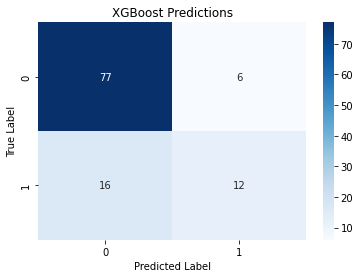

In [22]:
cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("XGBoost Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=10000)
param_grid = {'C': np.logspace(-4, 4, 11)}
logistic_grid = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
logistic_grid.fit(X_train, y_train)
best_params = logistic_grid.best_params_
best_score = logistic_grid.best_score_
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)
y_pred = logistic_grid.predict(X_test)
score = f1_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (score * 100.0))

Best Hyperparameters: {'C': 251.18864315095823}
Best Score: 0.7901115401115403
Accuracy: 52.17%


In [228]:
y_test

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0], dtype=int64)

In [229]:
y_pred

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [231]:
# layoflogistic_grid.predict_proba(X_test)
layoff_prob = logistic_grid.predict_proba(X_test)[:,1]

## Naive Bayes

In [236]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
# param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
param_grid = {'alpha': np.logspace(-4, 4, 11)}
gaussian_grid = GridSearchCV(mnb, param_grid, cv=3, n_jobs=-1)
gaussian_grid.fit(X_train, y_train)
best_params = gaussian_grid.best_params_
best_score = gaussian_grid.best_score_
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)
y_pred = gaussian_grid.predict(X_test)
score = f1_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (score * 100.0))

ValueError: 
All the 33 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "c:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 774, in fit
    self._count(X, Y)
  File "c:\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 896, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "c:\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1408, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


In [28]:
# applying Random Forest to visualize feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [29]:
f1_score(rf.predict(X_test), y_test)

0.5128205128205129

(array([ 2., 15., 26.,  4.,  3.,  0.,  1.,  0.,  0.,  1.]),
 array([0.00085132, 0.00817418, 0.01549705, 0.02281991, 0.03014277,
        0.03746563, 0.04478849, 0.05211135, 0.05943421, 0.06675707,
        0.07407993]),
 <BarContainer object of 10 artists>)

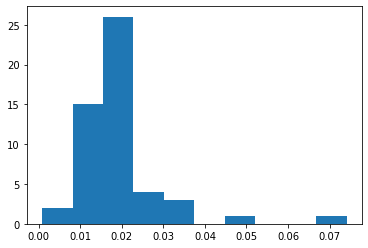

In [212]:
plt.hist(rf.feature_importances_)

In [162]:
f1_score(y_pred, y_test)

0.6588235294117647

Text(33.0, 0.5, 'True Label')

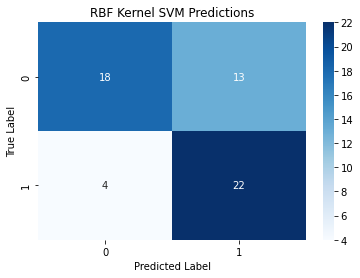

In [40]:
# spectral clustering
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=2, affinity='rbf', gamma=15, n_jobs=-1)

spectral.fit(data_kernel_pca)

c:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


SpectralClustering(gamma=15, n_clusters=2, n_jobs=-1)